# Political Evolution Simulator

This notebook implements a political simulation based on Selectorate Theory, where leaders evolve public/private goods allocation strategies over generations. Voters choose candidates based on ideology and expected benefits.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Parameters ---
N_VOTERS = 100             # Number of voters
N_CANDIDATES = 4           # Number of candidates
N_GENERATIONS = 2000       # Number of election cycles
RESOURCE_POOL = 1000       # Resources per candidate
PUBLIC_GOODS_MUT_STD = 0.01 # Mutation std dev for alpha
POLICY_MUT_STD = 2         # Mutation std dev for policy
THETA = 15                 # Ideological coalition inclusion threshold
TAU = 0.6                  # Risk-seeking voter threshold
PHI = 0.3                  # Risk-averse voter threshold

WIN_STREAK_RESORCES_REDUCTION = 0 # Resource reduction factor for winning streaks -> # winner.available_resources = RESOURCE_POOL / (1 + WIN_STREAK_RESORCES_REDUCTION * winner.win_streak)

np.random.seed(1234)


## Voter Class
Each voter has an ideology and a risk type. They vote based on policy alignment and payoff expectations.

In [12]:
# Classes Definition
class Voter:
    def __init__(self, ideology, risk_type='safe'):
        self.ideology = ideology
        self.risk_type = risk_type

    def utility(self, candidate, coalition_prob, included):
        policy_loss = -(self.ideology - candidate.policy) ** 2
        public_payoff = candidate.alpha * (candidate.available_resources / N_VOTERS)
        private_payoff = (1 - candidate.alpha) * (candidate.available_resources / N_VOTERS) if included else 0
        return policy_loss + public_payoff + private_payoff

    def inclusion(self, candidate, coalition_prob):
        threshold = TAU if self.risk_type == 'risk' else PHI
        return abs(self.ideology - candidate.policy) <= THETA and coalition_prob >= threshold


## Candidate Class
Candidates have a policy and public/private goods strategy. They mutate their strategy to evolve.

In [13]:
class Candidate:
    def __init__(self, policy, alpha, available_resources=RESOURCE_POOL, win_streak=0):
        self.policy = policy
        self.alpha = alpha
        self.supporters = set()
        self.winning_coalition = set()
        self.win_streak = win_streak
        self.available_resources = available_resources

    def mutate(self, mutate_policy=True):
        new_alpha = np.clip(self.alpha + np.random.normal(0, PUBLIC_GOODS_MUT_STD), 0, 1)
        new_policy = self.policy + np.random.normal(0, POLICY_MUT_STD) if mutate_policy else self.policy
        new_policy = np.clip(new_policy, 0, 100)
        return Candidate(new_policy, new_alpha)


## Simulation Class
Handles the election process, coalition formation, and candidate evolution.

In [14]:
class ElectionSim:
    def __init__(self):
        self.voters = [Voter(np.random.uniform(0, 100), np.random.choice(['safe', 'risk'])) for _ in range(N_VOTERS)]
        self.candidates = [Candidate(np.random.uniform(0, 100), np.random.uniform(0, 1)) for _ in range(N_CANDIDATES)]

    def run_generation(self, mutate_policy=True):
        ballots = []
        for voter in self.voters:
            utilities = []
            for cand in self.candidates:
                coalition_prob = len(cand.winning_coalition) / N_VOTERS if cand.winning_coalition else 1/N_VOTERS
                included = voter.inclusion(cand, coalition_prob)
                utilities.append(voter.utility(cand, coalition_prob, included))
            ballots.append(np.argmax(utilities))

        for idx, cand in enumerate(self.candidates):
            cand.supporters = {i for i, b in enumerate(ballots) if b == idx}
            supporters_list = list(cand.supporters)
            np.random.shuffle(supporters_list)
            cand.winning_coalition = set(supporters_list[:int(0.5 * N_VOTERS)])

        winner_idx = np.argmax([len(c.winning_coalition) for c in self.candidates])
        winner = self.candidates[winner_idx]

        winner.win_streak += 1
        winner.available_resources = RESOURCE_POOL / (1 + WIN_STREAK_RESORCES_REDUCTION * winner.win_streak)

        new_candidates = []
        for idx, cand in enumerate(self.candidates):
            if idx == winner_idx:
                new_candidates.append(winner)
            else:
                mutated_candidate = winner.mutate(mutate_policy)
                new_candidates.append(Candidate(mutated_candidate.policy, mutated_candidate.alpha))

        self.candidates = new_candidates
        return winner, winner_idx, self.candidates

    def run_simulation(self, generations=N_GENERATIONS, mutate_policy=True):
        history = []
        for gen in range(generations):
            winner, winner_idx, candidates = self.run_generation(mutate_policy=mutate_policy)
            for idx, cand in enumerate(candidates):
                history.append({
                    'generation': gen,
                    'candidate_id': idx,
                    'policy': cand.policy,
                    'alpha': cand.alpha,
                    'is_winner': (cand == winner),
                    'winner_idx': winner_idx,
                    'win_streak': cand.win_streak,
                    'available_resources': cand.available_resources
                })
        return pd.DataFrame(history)

## Run Simulation
Execute the simulation and observe the evolution of candidate strategies over generations.

In [15]:
sim = ElectionSim()
df = sim.run_simulation(mutate_policy=True)

## Plot Results
Visualize how winning policies and public/private allocations evolve over time.

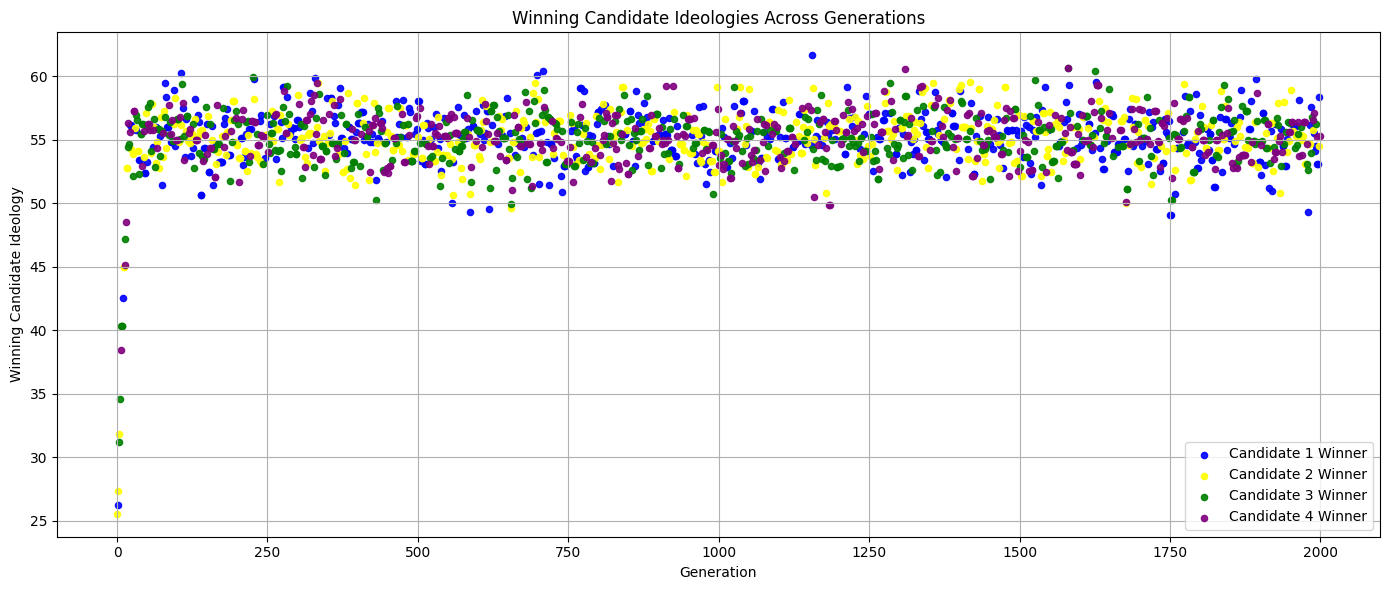

In [16]:
# Plot ideologies
colors = ['blue', 'yellow', 'green', 'purple']

plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[(df["candidate_id"] == idx) & (df["is_winner"])]
    plt.scatter(subset["generation"], subset["policy"], color=colors[idx], alpha=0.9, s=20, label=f'Candidate {idx+1} Winner')

plt.xlabel("Generation")
plt.ylabel("Winning Candidate Ideology")
plt.title("Winning Candidate Ideologies Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

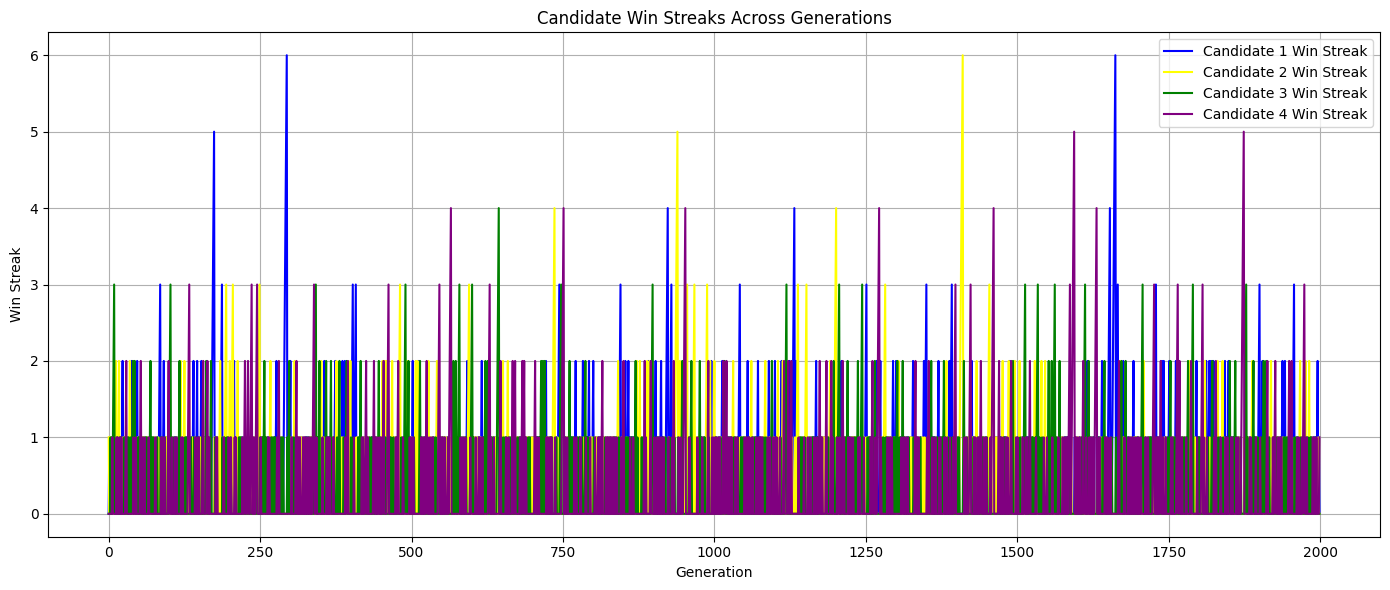

In [17]:
# Plot Win Streaks
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[df["candidate_id"] == idx]
    plt.plot(subset["generation"], subset["win_streak"], label=f'Candidate {idx+1} Win Streak', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Win Streak")
plt.title("Candidate Win Streaks Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


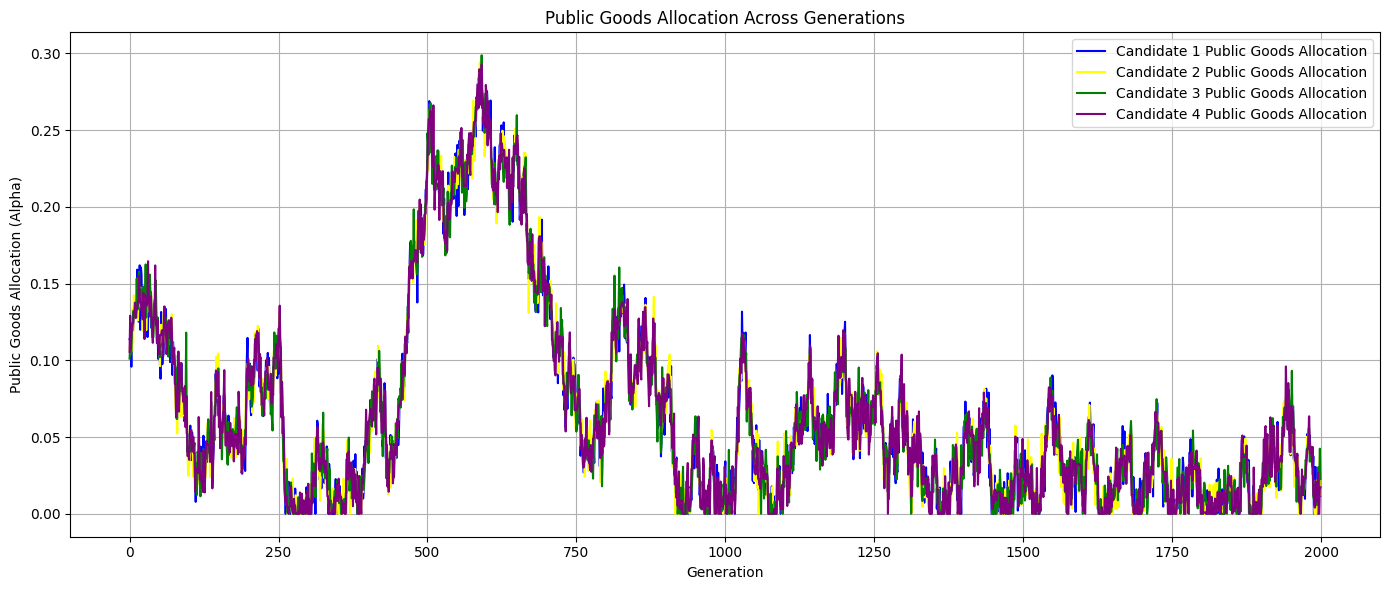

In [18]:
# Plot Public Goods Allocation
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[df["candidate_id"] == idx]
    plt.plot(subset["generation"], subset["alpha"], label=f'Candidate {idx+1} Public Goods Allocation', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Public Goods Allocation (Alpha)")
plt.title("Public Goods Allocation Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

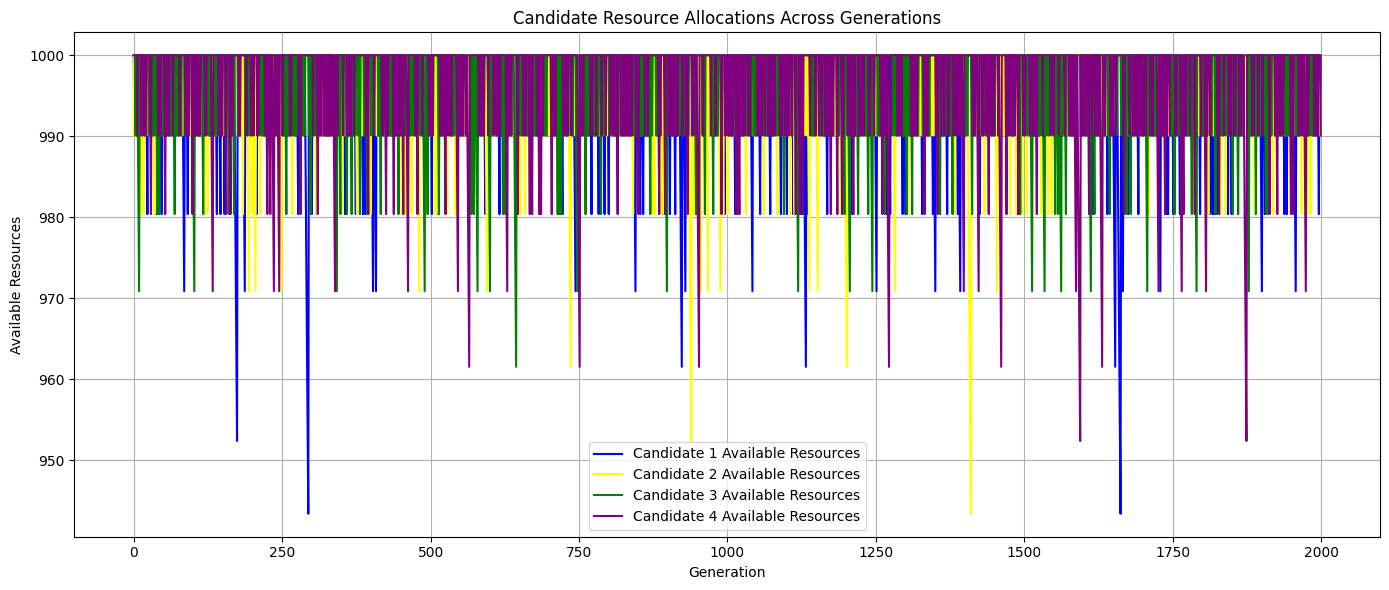

In [19]:
# Plot Resource Allocations
plt.figure(figsize=(14, 6))
for idx in range(N_CANDIDATES):
    subset = df[df["candidate_id"] == idx]
    plt.plot(subset["generation"], subset["available_resources"], label=f'Candidate {idx+1} Available Resources', color=colors[idx])

plt.xlabel("Generation")
plt.ylabel("Available Resources")
plt.title("Candidate Resource Allocations Across Generations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# --- Check for Cycles in Public and Private Goods Allocation ---
def detect_cycles(series, window=50):
    for i in range(len(series) - 2*window + 1):
        if np.allclose(series[i:i+window], series[i+window:i+2*window], atol=0.01):
            return True, i
    return False, -1

alpha_series = df[df['is_winner']]['alpha'].values
has_cycle, cycle_start = detect_cycles(alpha_series)

if has_cycle:
    print(f"Cycle detected starting around generation {cycle_start}")
else:
    print("No significant cycle detected; behavior likely random walk.")


No significant cycle detected; behavior likely random walk.
